<a href="https://colab.research.google.com/github/shubhrojitmisra/Computational-Neuroscience/blob/main/Computational_BCI_using_Python_MNE_Library_1st_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**# Step 1:** Environment Setup

In [1]:
#@title Setting up the environment
!pip install mne
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 6.1 MB/s eta 0:00:00


In [2]:
#@title Mounting Google Drive locally

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Importing required modules

from collections import OrderedDict
from pylab import rcParams
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import mne
from sklearn.preprocessing import RobustScaler

#**# Step 2:** Enabling Reproducibility 

In [4]:
#@title Setting seed to reproduce behaviour
tf.random.set_seed(100)

Initialize parameters including EEG related Metadata.


*   **eeg_sample_count**:  Number of samples being trained in the current network
*   **learning_rate**:     The rate the network tends to change/update its weights while learning
*   **eeg_sample_length**: Number of EEG datapoints per sample
*   **number_of_classes**: Number of output classes (a scalar value representing the probability of the input belonging to the category of a P300 wave)
*   **hidden1**: Number of neurons in the first hidden layer
*   **hidden2**: Number of neurons in the second hidden layer
*   **hidden3**: Number of neurons in the third hidden layer
*   **penultimate**: Number of neurons in the penultimate layer


In [5]:
eeg_sample_count = 240 
learning_rate = 1e-3 
eeg_sample_length = 226 
number_of_classes = 1 
hidden1 = 500 
hidden2 = 1000 
hidden3 = 100 
penultimate = 10 

# **# Step 3:** Data Retrieval from the MNE EEG Database 

In [6]:
#@title The MNE library specializes in brain signal processing and provides access to sample datasets

data_path = mne.datasets.sample.data_path()
data_path

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 618GB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


PosixPath('/root/mne_data/MNE-sample-data')

In [ ]:
#!cp /root/mne_data/MNE-sample-data/ /content/MNE_data -r

In [41]:
#@title Data description 

# Setting path to the specific dataset used in this experiment
raw_fname = '/root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = '/root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'

# Obtain a reference to the database and preload into RAM
raw_data = mne.io.read_raw_fif(raw_fname, preload=True) 

# EEGs work by detecting the voltage between two points 
# The second reference point is set to be the average of all voltages using the following function
raw_data.set_eeg_reference()

# It is also possible to set the reference voltage to a different number

Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Created an SSP operator (subspace dimension = 3)


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.9 MB, data loaded>

In [42]:
#@title Defining the type of data required from the dataset

raw_data = raw_data.pick(picks=["eeg","eog"])
picks_eeg_only = mne.pick_types(raw_data.info, 
                                eeg=True, 
                                eog=True, 
                                meg=False, 
                                exclude='bads')

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


In [43]:
#@title Recognising events and epochs from the data

events = mne.read_events(event_fname)
event_id = 5
tmin = -0.5 
tmax = 1
epochs = mne.Epochs(raw_data, events, event_id, tmin, tmax, proj=True,
                    picks=picks_eeg_only, baseline=(None, 0), preload=True,
                    reject=dict(eeg=100e-6, eog=150e-6), verbose = False)
print(epochs)

<Epochs |  12 events (all good), -0.499488 - 0.998976 sec, baseline -0.499488 – 0 sec, ~4.2 MB, data loaded,
 '5': 12>


This data has 12 P300 samples and 64 sensors/channels. Here in this experiment only one sensor/channel has been utilised.

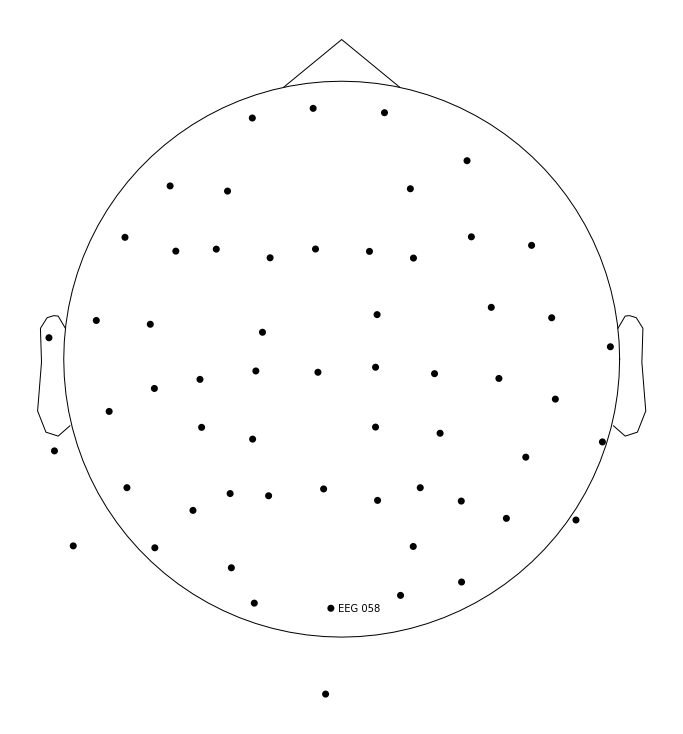

In [44]:
#@title Sensor Position Sketch

# This is the channel used to monitor the P300 response
channel = "EEG 058"

# Display a sketch of the positions of the sensors whose data that are being used in this experiment
sensor_position_figure = epochs.plot_sensors(show_names=[channel])

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated


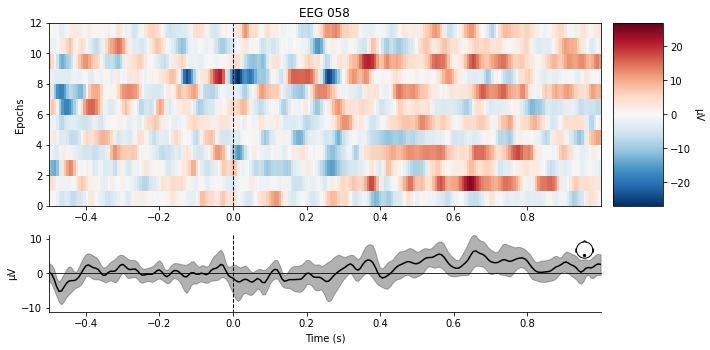

[<Figure size 720x360 with 4 Axes>]

In [45]:
#@title Heat Graph representation of the 12 P300 epochs

epochs.plot_image(picks=channel)

The above heat graph represents the 12 P300 events found within the dataset. If monitored closely around the `0.3sec -> 0.4sec` mark, a noticable deflection in the signal can be seen, which is the **P300 component**.

In [46]:
#@title Extracting the non-P300 samples

event_id=[1,2,3,4]
epochsNoP300 = mne.Epochs(raw_data, events, event_id, tmin, tmax, proj=True,
                    picks=picks_eeg_only, baseline=(None, 0), preload=True,
                    reject=dict(eeg=100e-6, eog=150e-6), verbose = False)
print(epochsNoP300)

<Epochs |  208 events (all good), -0.499488 - 0.998976 sec, baseline -0.499488 – 0 sec, ~24.5 MB, data loaded,
 '1': 47
 '2': 56
 '3': 57
 '4': 48>


There are significantly more non-P300 events in this dataset, so only a subset has been used to keep the requisite balance between class data. The most important observation about the plot below is that there is no significant deflection around the `0.3sec -> 0.4sec` time interval for the average of the data.

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated


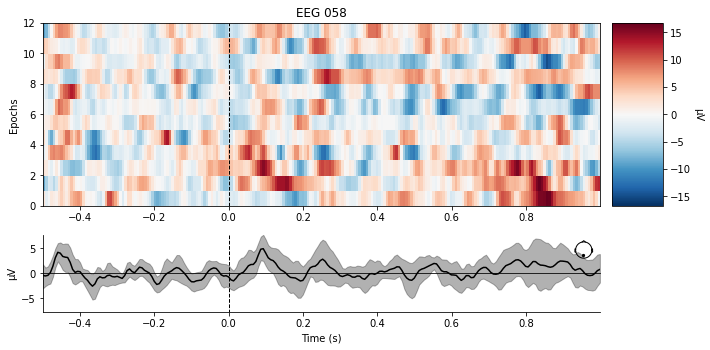

[<Figure size 720x360 with 4 Axes>]

In [47]:
#@title Heat Graph representation of the non-P300 epochs

epochsNoP300[0:12].plot_image(picks=channel)

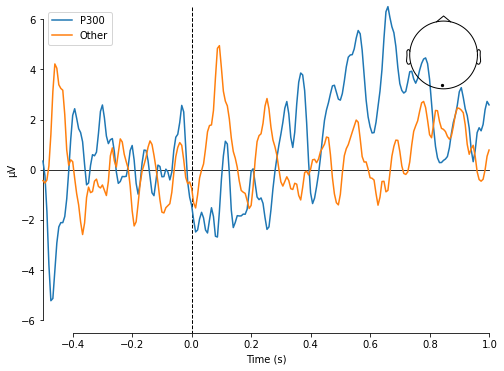

[<Figure size 576x432 with 2 Axes>]

In [48]:
#@title All-in-one graph

mne.viz.plot_compare_evokeds({'P300': epochs.average(picks=channel), 'Other': epochsNoP300[0:12].average(picks=channel)})

The above all-in-one graph is used to visualize what these samples look like. The blue line corresponds to when the subject was shown a smiley face, and the orange line corresponds to when the subject was shown a checkerboard.

The following tasks have been performed in the next cell:-

*   Scaling and reducing dimensions of the data while being mindful of possible outliers. If scaling is performed only using the minimum and the maximum values of the dataset, there stands the the risk of the data getting defined by outliers, thus squeezing the regular values in the center. To avoid this, the data has been scaled with respect to some statistical values that correspond to a few standard deviations from the mean.
*   Creating a label variable, where the P300 samples are labeled as 1 and the non-P300 samples are labeled as 0.
*   Combining the data into a single data structure and performing various data type conversions so that .

In [49]:
#@title Preprocessing & Dimensionality Reduction

eeg_data_scaler = RobustScaler()

# We have 12 p300 samples
p300s = np.squeeze(epochs.get_data(picks=channel))
raw_p300_data = np.copy(p300s)

# We have 208 non-p300 samples
others = np.squeeze(epochsNoP300.get_data(picks=channel))

# Scale the p300 data using the RobustScaler
p300s = p300s.transpose()
p300s = eeg_data_scaler.fit_transform(p300s)
p300s = p300s.transpose()

# Scale the non-p300 data using the RobustScaler
others = others.transpose()
others = eeg_data_scaler.fit_transform(others)
others = others.transpose()

## Prepare the train and test tensors
# Specify Positive P300 train and test samples
p300s_train = p300s[0:9]
p300s_test = p300s[9:12]
p300s_test = p300s_test.astype('float')

# Specify Negative P300 train and test samples
others_train = others[30:39]
others_test = others[39:42]
others_test = others_test.astype('float')

# Combine everything into their final structures
training_data = np.concatenate((p300s_train, others_train), axis = 0).astype('float')
positive_testing_data = p300s_test.astype('float')
negative_testing_data = others_test.astype('float')

# Print the size of each of our data structures
print("training data count: " + str(training_data.shape[0]))
print("positive testing data count: " + str(positive_testing_data.shape[0]))
print("negative testing data count: " + str(negative_testing_data.shape[0]))

# Generate training labels
labels = np.zeros((training_data.shape[0],1)).astype('float')
labels[0:10] = 1.0
print("training labels count: " + str(labels.shape[0]))

training data count: 18
positive testing data count: 3
negative testing data count: 3
training labels count: 18


In [50]:
raw_p300_data

array([[-1.06680518e-06, -2.57997091e-07,  1.73738163e-07, ...,
         3.02087465e-06,  1.95182893e-06, -5.53783644e-07],
       [ 4.98177722e-06,  4.07637476e-06,  2.84493809e-06, ...,
         3.33417175e-06,  3.13858096e-06,  3.43232678e-06],
       [-1.05547409e-05, -1.26039723e-05, -1.34913226e-05, ...,
        -1.49012707e-06, -1.83347005e-06, -3.47715572e-06],
       ...,
       [ 7.92946383e-06,  5.25816212e-06,  7.41109139e-07, ...,
         1.27263603e-05,  1.35641789e-05,  1.15924837e-05],
       [-1.31440508e-06, -1.72188404e-06, -1.76087366e-06, ...,
        -2.54264612e-06, -2.62112048e-07,  2.58182518e-06],
       [-2.45535004e-07,  5.01532319e-07,  9.49239162e-07, ...,
         2.16227035e-06,  2.71091359e-06,  3.19583981e-06]])

In [51]:
raw_p300_data.min()

-2.6854482076907355e-05

In [52]:
training_data

array([[ 8.92232915e-05,  1.65585160e-01,  2.53925560e-01, ...,
         8.36498269e-01,  6.17753272e-01,  1.05062184e-01],
       [ 3.49270995e-01,  2.41627188e-01,  9.52209902e-02, ...,
         1.53386255e-01,  1.30132356e-01,  1.65055961e-01],
       [-1.47538619e+00, -1.79694852e+00, -1.93619019e+00, ...,
        -5.29805588e-02, -1.06857425e-01, -3.64782120e-01],
       ...,
       [ 2.42015015e-01,  8.01692659e-02,  1.92581911e-01, ...,
        -8.70671560e-01, -6.99694215e-01, -3.96276501e-01],
       [ 6.28427852e-01,  4.78101527e-01,  4.77429047e-01, ...,
        -1.51822084e+00, -1.21172349e+00, -9.97428230e-01],
       [ 6.92947268e-01,  3.20167279e-01,  2.95440564e-01, ...,
         1.78764342e-01,  7.37147179e-03,  1.25337755e-01]])

In [53]:
training_data.min()

-4.433906428357594

# **# Step 4:** The Deep Neural Network

This neural network has several distinct customizable components. Below, the network graph is defined as sets of linear nodes and activation nodes. The input data will travel along this graph, accumulate biases, get scaled by weights and transformed by activation functions, until it passes through the final output node. It is then fed to a sigmoid function which scales the final value to a number between 0 and 1.

This final number is the P300 predictor.





In [54]:
#@title Initialising the Neural Network

# Define the network
sequential_model = keras.Sequential()

# Input Layer (Size 226 -> 500)
sequential_model.add(layers.Dense(hidden1, activation="selu", name="Input_Layer"))

# Hidden Layer (Size 500 -> 1000)
sequential_model.add(layers.Dense(hidden2, activation="relu", name="Hidden_Layer1"))

# Hidden Layer (Size 1000 -> 100)
sequential_model.add(layers.Dense(hidden3, activation="relu", name="Hidden_Layer2"))

# Hidden Layer (Size 100 -> 10)
sequential_model.add(layers.Dense(penultimate, activation="relu", name="Hidden_Layer3"))

# Output Layer (Size 10 -> 1)
sequential_model.add(layers.Dense(number_of_classes, activation="sigmoid", name="Output_Layer"))

In [55]:
# Define a loss function
#loss_function = keras.losses.MeanSquaredError()

# Define a learning function, needs to be reinitialized on every load
optimizer = keras.optimizers.Adam(lr=learning_rate)

# After the model is created, we then configure the model with losses and metrics
sequential_model.compile(optimizer=optimizer,
             loss='mse',
             metrics=['mse'])

# Save the network's default state so we can retrain from the default weights
#sequential_model.save('/home/sequential_model_default_state')

Next, let's define training loss function as MSE (mean squared error).

Keras provide an efficient wrapper to combine loss and training with the model.complie() function. 

It automatically calculates the loss and updates the network's weights at every iteration.

Using the network definition created in Step 5, we'll train on our real EEG data this time, beginning from defaulted weights, prior to any training with the sample data we created.

# **# Step 5:** Classifying data with the Deep Neural Network

Loss graph for dataset training session


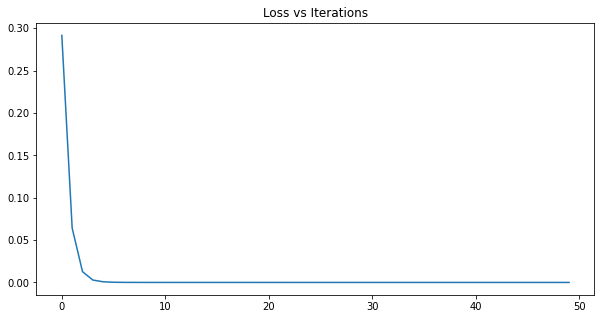

In [56]:
# Make sure we're starting from untrained every time
#sequential_model = keras.models.load_model('/content/drive/home/sequential_model_default_state')

mse_list = sequential_model.fit(training_data, labels, epochs = 50, verbose=0)

# Define a learning function, needs to be reinitialized on every load
#optimizer = torch.optim.Adam(sequential_model.parameters(), lr = learning_rate)

# Use our training procedure with the sample data
print("Loss graph for dataset training session")
loss_data = mse_list.history['loss']

# Plot a loss graph at the end of training
rcParams['figure.figsize'] = 10, 5
plt.title("Loss vs Iterations")
plt.plot(list(range(0, len(loss_data))), loss_data)
plt.show()

Alright, the moment of truth! Let's classify our test data sets.

In [57]:
# Classify our positive test dataset and print the results
classification_1 = sequential_model.predict(positive_testing_data)
for index, value in enumerate(classification_1.data.tolist()):
  print("P300 Positive Classification {1}: {0:.2f}%".format(value[0] * 100, index + 1))

print()

# Classify our negative test dataset and print the results
classification_2 = sequential_model.predict(negative_testing_data)
for index, value in enumerate(classification_2.data.tolist()):
  print("P300 Negative Classification {1}: {0:.2f}%".format(value[0] * 100, index + 1))

1/1 [==============================] - 0s 81ms/step
P300 Positive Classification 1: 100.00%
P300 Positive Classification 2: 99.64%
P300 Positive Classification 3: 99.97%

1/1 [==============================] - 0s 26ms/step
P300 Negative Classification 1: 99.86%
P300 Negative Classification 2: 74.28%
P300 Negative Classification 3: 94.26%


As you can see that most P300 Positive test samples did very well but one of the P300 Negative samples was misclassified. This happens when we have less training data aka *underfitting*. The network was unable to discern the difference between one of the Negative samples and the rest of the Positive samples. Let's take a look at what these samples look like next to each other.

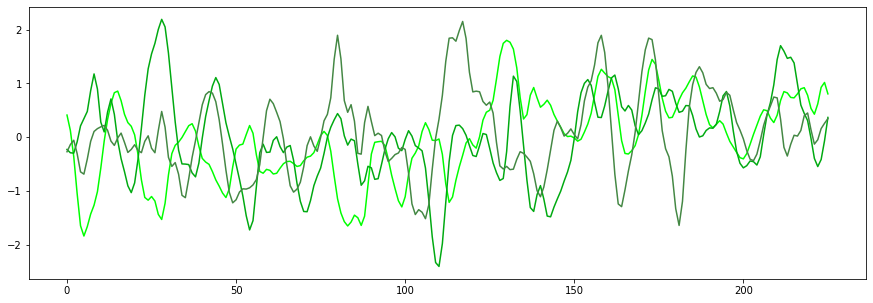

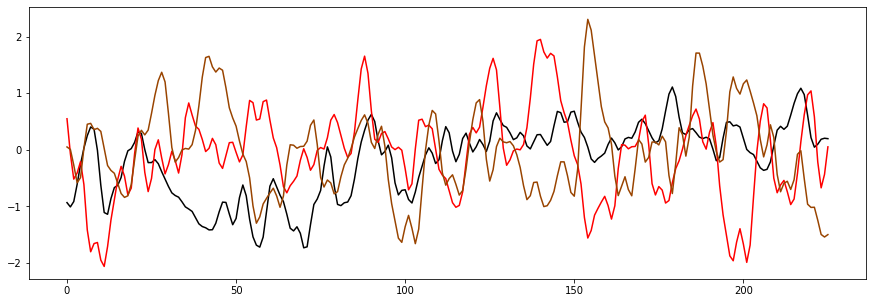

In [58]:
rcParams['figure.figsize'] = 15, 5

plt.plot(list(range(0, eeg_sample_length)), positive_testing_data[0], color = "#00ff00")
plt.plot(list(range(0, eeg_sample_length)), positive_testing_data[1], color = "#00aa11")
plt.plot(list(range(0, eeg_sample_length)), positive_testing_data[2], color = "#448844")
plt.show()
plt.plot(list(range(0, eeg_sample_length)), negative_testing_data[0], color = "black")
plt.plot(list(range(0, eeg_sample_length)), negative_testing_data[1], color = "r")
plt.plot(list(range(0, eeg_sample_length)), negative_testing_data[2], color = "#994400")
plt.show()

So what happened here? The black line on the second graph is our offender. Visually, it looks similar enough to the Positive samples that it could easily be mistaken for one. Our network would require siginificantly more examples before it could distinguish samples like this.

Generally, it's recommended to have at least 100 samples to train on for each class. In this case we only had 9! Not enough for a true application, but enough for a proof of concept. With more samples, the network can develop a more complex and robust solution to classification.

# **# Step 6:** Analysing the collected data

Here, we'd like to train the EEG data collected just now.
First, we should load the .mat data and get EEG data and its corresponding labels.

In [59]:
import scipy.io as sio

In [67]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
P300_file_3 = sio.loadmat('/content/drive/MyDrive/BCI & Computational Neuroscience/BCI UTS Australia Workshop/P300Data3.mat')
#print('P300 file contents',P300_file.keys())
P300_data_3 = P300_file_3['Data']

# select the 5-th channel as the training data
P300_data_c5 = P300_data_3[4, :].transpose()

## NORMALIZING
scaler = MinMaxScaler()
scaler.fit(P300_data_c5)

P300_data_c5 = scaler.transform(P300_data_c5)

P300_label = P300_file_3['Labels']



from sklearn.model_selection import train_test_split
P300_data_c5_train, P300_data_c5_test, P300_label_c5_train, P300_label_c5_test = train_test_split(P300_data_c5, P300_label, test_size=0.2, random_state=123)

print(P300_data_c5_train.shape)
print(P300_data_c5_test.shape)

(200, 750)
(50, 750)


In [71]:
P300_file_2 = sio.loadmat('/content/drive/MyDrive/BCI & Computational Neuroscience/BCI UTS Australia Workshop/P300Data2.mat')
#print('P300 file contents',P300_file.keys())
P300_data_2 = P300_file_2['Data']
# select the 5-th channel as the training data
P300_data_c5_2 = P300_data_2[6, :, 120:150].transpose()
P300_label_2 = P300_file_2['Labels'][120:150]

P300_file_1 = sio.loadmat('/content/drive/MyDrive/BCI & Computational Neuroscience/BCI UTS Australia Workshop/P300Data.mat')
#print('P300 file contents',P300_file.keys())
P300_data_1 = P300_file_1['Data']
# select the 5-th channel as the training data
P300_data_c5_1 = P300_data_1[4, :, 120:150].transpose()
P300_label_1 = P300_file_1['Labels'][120:150]

P300_data_c5 = np.concatenate((P300_data_c5_1, P300_data_c5_2), axis=0)
P300_label = np.concatenate((P300_label_1, P300_label_2), axis=0)

from sklearn.model_selection import train_test_split
P300_data_c5_train, P300_data_c5_test, P300_label_c5_train, P300_label_c5_test = train_test_split(P300_data_c5, P300_label, test_size=0.2, random_state=123)

print(P300_data_c5_train.shape)
print(P300_data_c5_test.shape)



(48, 600)
(12, 600)


In [72]:
## Define the network
P300_model = keras.Sequential()

# Input Layer (Size 226 -> 500)
P300_model.add(layers.Dense(hidden1, activation="relu", name="Input_Layer"))

# Hidden Layer (Size 500 -> 1000)
P300_model.add(layers.Dense(hidden2, activation="relu", name="Hidden_Layer1"))

# Hidden Layer (Size 1000 -> 100)
P300_model.add(layers.Dense(hidden3, activation="relu", name="Hidden_Layer2"))

# Hidden Layer (Size 100 -> 10)
P300_model.add(layers.Dense(penultimate, activation="relu", name="Hidden_Layer3"))

# Output Layer (Size 10 -> 1)
P300_model.add(layers.Dense(number_of_classes, activation="sigmoid", name="Output_Layer"))

# Define a learning function, needs to be reinitialized every load
optimizer = keras.optimizers.Adam(lr=0.001)
# After the model is created, we then config the model with losses and metrics
P300_model.compile(optimizer=optimizer,
             loss='mse',
             metrics=['mse'])

Loss graph for dataset training session


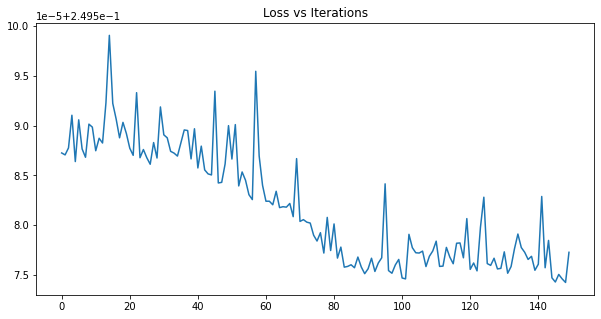

In [75]:
# Make sure we're starting from untrained every time
#sequential_model = keras.models.load_model('/home/sequential_model_default_state')
#tf.compat.v1.initializers.global_variables()
mse_list = P300_model.fit(P300_data_c5_train, P300_label_c5_train, epochs = 150, verbose=0)

# Define a learning function, needs to be reinitialized every load
# optimizer = torch.optim.Adam(tutorial_model.parameters(), lr = learning_rate)

# Use our training procedure with the sample data
print("Loss graph for dataset training session")
loss_data = mse_list.history['loss']
# Plot a nice loss graph at the end of training
rcParams['figure.figsize'] = 10, 5
plt.title("Loss vs Iterations")
plt.plot(list(range(0, len(loss_data))), loss_data)
plt.show()

In [77]:
# Classify our positive test dataset and print the results
classification_test = np.round(P300_model.predict(P300_data_c5_test))
from sklearn.metrics import classification_report
print(classification_report(P300_label_c5_test, classification_test))


1/1 [==============================] - 0s 28ms/step
              precision    recall  f1-score   support

           0       0.42      1.00      0.59         5
           1       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Getting P300Data3 readings

In [78]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
P300_file_3 = sio.loadmat('/content/drive/MyDrive/BCI & Computational Neuroscience/BCI UTS Australia Workshop/P300Data3.mat')
#print('P300 file contents',P300_file.keys())
P300_data_3 = P300_file_3['Data']

# select the 5-th channel as the training data
P300_data_c5 = P300_data_3[4, :].transpose()

## NORMALIZING
scaler = MinMaxScaler()
scaler.fit(P300_data_c5)

P300_data_c5 = scaler.transform(P300_data_c5)

P300_label = P300_file_3['Labels']



from sklearn.model_selection import train_test_split
P300_data_c5_train, P300_data_c5_test, P300_label_c5_train, P300_label_c5_test = train_test_split(P300_data_c5, P300_label, test_size=0.2, random_state=123)

print(P300_data_c5_train.shape)
print(P300_data_c5_test.shape)

(200, 750)
(50, 750)


In [68]:
## Define the network
P300_model = keras.Sequential()

# Input Layer (Size 226 -> 500)
P300_model.add(layers.Dense(hidden1, activation="relu", name="Input_Layer"))

# Hidden Layer (Size 500 -> 1000)
P300_model.add(layers.Dense(hidden2, activation="relu", name="Hidden_Layer1"))

# Hidden Layer (Size 1000 -> 100)
P300_model.add(layers.Dense(hidden3, activation="relu", name="Hidden_Layer2"))

# Hidden Layer (Size 100 -> 10)
P300_model.add(layers.Dense(penultimate, activation="relu", name="Hidden_Layer3"))

# Output Layer (Size 10 -> 1)
P300_model.add(layers.Dense(number_of_classes, activation="sigmoid", name="Output_Layer"))

# Define a learning function, needs to be reinitialized every load
optimizer = keras.optimizers.Adam(lr=0.001)
# After the model is created, we then config the model with losses and metrics
P300_model.compile(optimizer=optimizer,
             loss='mse',
             metrics=['mse'])

Loss graph for dataset training session


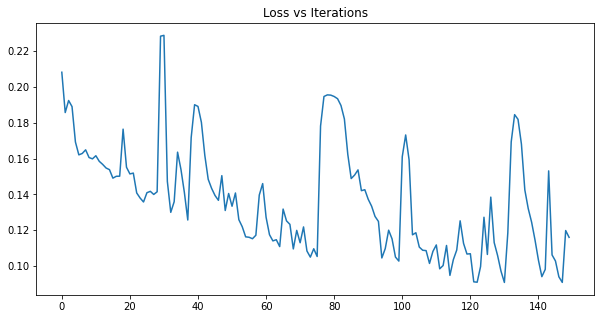

In [69]:
# Make sure we're starting from untrained every time
#sequential_model = keras.models.load_model('/home/sequential_model_default_state')
#tf.compat.v1.initializers.global_variables()
mse_list = P300_model.fit(P300_data_c5_train, P300_label_c5_train, epochs = 150, verbose=0)

# Define a learning function, needs to be reinitialized every load
# optimizer = torch.optim.Adam(tutorial_model.parameters(), lr = learning_rate)

# Use our training procedure with the sample data
print("Loss graph for dataset training session")
loss_data = mse_list.history['loss']
# Plot a nice loss graph at the end of training
rcParams['figure.figsize'] = 10, 5
plt.title("Loss vs Iterations")
plt.plot(list(range(0, len(loss_data))), loss_data)
plt.show()

In [70]:
# Classify our positive test dataset and print the results
classification_test = np.round(P300_model.predict(P300_data_c5_test))
from sklearn.metrics import classification_report
print(classification_report(P300_label_c5_test, classification_test))


2/2 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.95      0.90      0.92        40

    accuracy                           0.88        50
   macro avg       0.81      0.85      0.83        50
weighted avg       0.89      0.88      0.88        50



To do next

In [ ]:
## Define the network
class MyModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    # Input Layer (Size 226 -> 500)
    self.input_layer = tf.keras.layers.Dense(hidden1, activation="selu", name="Input_Layer")
    # Hidden Layer (Size 500 -> 1000)
    self.hidden_layer1 = tf.keras.layers.Dense(hidden2, activation="relu", name="Hidden_Layer1")
    # Hidden Layer (Size 1000 -> 100)
    self.hidden_layer2 = tf.keras.layers.Dense(hidden3, activation="relu", name="Hidden_Layer2")
    # Hidden Layer (Size 100 -> 10)
    self.hidden_layer3 = tf.keras.layers.Dense(10, activation="relu", name="Hidden_Layer3")
    # Output Layer (Size 10 -> 1)
    self.ouput_layer = tf.keras.layers.Dense(number_of_classes, activation="sigmoid", name="Output_Layer")

  def call(self, inputs):
    o_input_layer = self.input_layer(inputs)
    o_hidden_layer1 = self.hidden_layer1(o_input_layer)
    o_hidden_layer2 = self.hidden_layer2(o_hidden_layer1)
    o_hidden_layer3 = self.hidden_layer3(o_hidden_layer2)
    o_ouput_layer = self.ouput_layer(o_hidden_layer3)
    return o_ouput_layer

sequential_model = MyModel()
